# Mini Project 1: MNSIT Pair Comparison

In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue
import pandas as pd
from IPython.display import display, Markdown


In [465]:
from torch import nn
import torch

print_off = True

class Print(torch.nn.Module):
    def __init__(self, string=''):
        super(Print, self).__init__()
        self.string=string
        
    def forward(self, x):
        if print_off: return x
        print(self.string)
        print(x.shape)
        return x

    
    
#method to flatten the images
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return torch.reshape(x, (batch_size, -1))
## Architectures: 

# The architecture represents the part of the model that recognizes the images.

# Deep

# Note: arch1,arch2,arch3 are functions that instanciate a new architecture not  architectures !
arch1 = lambda :  nn.Sequential(                     # input shape (100, 2, 14, 14)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=35,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=1,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 7, 7)
            nn.Conv2d(35, 32, 5, 1, 4),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
            Print('a'),
            Flatten(),        
            Print('b'),
            nn.Linear(800,25),              # fully connected layer, output 10 classes
            nn.Linear(25,25), 
            nn.Linear(25, 10) ,             # fully connected layer, output 10 classes
            nn.BatchNorm1d(10),
            nn.ReLU())


# Fully connected

arch2 = lambda  : nn.Sequential(                      # input shape (1, 28, 28)
            Print('a'),
            Flatten(),
            Print('b'),
            nn.Linear(196, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, 56),
            nn.ReLU(),
            nn.Linear(56, 10),              
            nn.ReLU()
            )



# Deep with sigmoids

arch3 = lambda :  nn.Sequential(                     # input shape (100, 2, 14, 14)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=35,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=1,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 14, 14)
            nn.Sigmoid(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 7, 7)
            nn.Conv2d(35, 32, 5, 1, 4),     # output shape (32, 14, 14)
            nn.Sigmoid(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
            Print('a'),
            Flatten(),        
            Print('b'),
            nn.Linear(800,25),              # fully connected layer, output 10 classes
            nn.Linear(25,25), 
            nn.Linear(25, 10) ,             # fully connected layer, output 10 classes
            nn.BatchNorm1d(10),
            nn.Sigmoid())







class CNN(nn.Module):
    ''' To create this class use CNN(True, 'deep) for example.
    other options are False, 'deep with sigmoids' and 'fully connected'. '''
 
    def __init__(self, weight_sharing, architecture):
        super(CNN, self).__init__()
        self.weight_sharing = weight_sharing
        self.architecture = architecture

        # select the proper architecture
        if architecture == 'deep':
            # arch_copy is used with no weight sharing only
            self.arch = arch1()
            self.arch_copy = arch1()
        if architecture == 'deep with sigmoids':
            self.arch = arch3()
            self.arch_copy = arch3()
        if architecture == 'fully connected':
            self.arch = arch2()
            self.arch_copy = arch2()

        self.fc = nn.Sequential(
            nn.Linear(20, 1) ,  # fully connected layer, output 10 classes
            nn.BatchNorm1d(1),
            nn.Dropout(0.05),
            nn.Sigmoid()
        )
    def reset(self):
        self.__init__(self.weight_sharing, self.architecture)
    
    
    def forward(self, x):
        #first convolutional layer


        _x = torch.reshape(x[:,0,:,:], (-1, 1, 14, 14))
        _x1 = self.arch(_x)
        _x = torch.reshape(x[:,1,:,:], (-1, 1, 14, 14))

        # if there is no weight sharing use the arch_copy layers
        if self.weight_sharing: _x2 = self.arch(_x)
        else: _x2 = self.arch_copy(_x)

        #concatenate and retrun auxilary output
        _x = torch.cat((_x1, _x2), 1)   
        aux_out = (_x1, _x2)


        #fc layer to merge the two recognitions
        _x = self.fc(_x)
        
        # we print _x[:,0] because otherwise _x is of size (N,1) which is not usefull 
        # it should be of size (N)
        return aux_out, _x[:,0]






In [466]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

    


In [467]:
DATA=pd.DataFrame(columns = ['architecture', 
                             'training mode',
                             'weight sharing', 
                             'history',
                             'model', 
                            'loss function'])

for architecture in ['deep', 'fully connected', 'deep with sigmoids']:
    for weight_sharing in [True, False]:
        for training_mode in ['without auxiliar loss', 'with auxiliar loss']:
            
            model = CNN(weight_sharing, architecture)
            
            if training_mode == 'without auxiliar loss':
                loss_function = lambda loss_main, loss_aux: loss_main
            elif training_mode == 'with auxiliar loss':
                loss_function = lambda loss_main, loss_aux: loss_main + loss_aux
            else:
                raise Exception('wrong loss function')
            
            # history is an dictionary we created to store the values required to plot the graph
            
            DATA = DATA.append({'architecture':architecture,
                               'training mode': training_mode,
                               'weight sharing': weight_sharing,
                               'history': pd.DataFrame(),
                               'model':model,
                               'loss function':loss_function,
                               'number parameters': count_parameters(model)},
                               ignore_index=True)


In [468]:
DATA

,architecture,training mode,weight sharing,history,model,loss function,number parameters
0,deep,without auxiliar loss,True,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Conv2d(1...,<function <lambda> at 0x7fb283825620>,98697.0
1,deep,with auxiliar loss,True,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Conv2d(1...,<function <lambda> at 0x7fb28383a6a8>,98697.0
2,deep,without auxiliar loss,False,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Conv2d(1...,<function <lambda> at 0x7fb2838e1598>,98697.0
3,deep,with auxiliar loss,False,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Conv2d(1...,<function <lambda> at 0x7fb283a0e510>,98697.0
4,fully connected,without auxiliar loss,True,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Print()\...,<function <lambda> at 0x7fb283a259d8>,99067.0
5,fully connected,with auxiliar loss,True,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Print()\...,<function <lambda> at 0x7fb283c3aea0>,99067.0
6,fully connected,without auxiliar loss,False,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Print()\...,<function <lambda> at 0x7fb283c27378>,99067.0
7,fully connected,with auxiliar loss,False,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Print()\...,<function <lambda> at 0x7fb283baf840>,99067.0
8,deep with sigmoids,without auxiliar loss,True,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Conv2d(1...,<function <lambda> at 0x7fb283b897b8>,98697.0
9,deep with sigmoids,with auxiliar loss,True,Empty DataFrame Columns: [] Index: [],CNN(\n (arch): Sequential(\n (0): Conv2d(1...,<function <lambda> at 0x7fb283ae0730>,98697.0


In [200]:
# Load the data
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [201]:
# un hot-encode train and test classes to use the function nn.CrossEntropyLoss() 
train_classes = train_classes.argmax(dim = 2)
test_classes = test_classes.argmax(dim = 2)

RuntimeError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [437]:
test_classes, train_classes

(tensor([[4, 2],
         [7, 6],
         [7, 9],
         ...,
         [8, 8],
         [3, 3],
         [8, 6]]), tensor([[6, 1],
         [8, 5],
         [0, 7],
         ...,
         [5, 0],
         [8, 6],
         [3, 8]]))

In [11]:
# train and test classes to categorical
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.Tensor(np.eye(num_classes, dtype='uint8')[y]).type(torch.LongTensor)
train_classes, test_classes = to_categorical(train_classes, 10), to_categorical(test_classes, 10)

In [12]:
# function to compute classes accuracy
def accuracy_classes(predicted, target):
    '''
    computes the accuracy of the predicted classes in %
    '''

    predicted_1 = predicted[0]
    predicted_2 = predicted[1]
    predicted_1 = predicted_1.argmax(dim=1)
    predicted_2 = predicted_2.argmax(dim=1)
    target_1=target[:,0]
    target_2=target[:,1]
    return ( 100 -( ( (target_1 != predicted_1) | (target_2 != predicted_2 ) ).sum() ).item() /target_1.shape[0] * 100 )



In [13]:
def accuracy_comparison(predicted, target):
    '''computes accuracy for output'''
    return( np.array((torch.abs(predicted - target) < 0.5).sum().float() / target.shape[0] * 100))



In [188]:
# d is a history  containing the info of the training
def plot_graphs(data_row, d):
    # plotting accuracy
    plt.figure(figsize=(10,6))

    plt.subplot(1,2,1)


    description =  'model of type '+data_row['architecture']+',\n with lr= '+str(d['learning rate'])+\
    (', with weight sharing, ' if data_row['weight sharing'] else ', without weight sharing, ') +\
        'and loss function '+ data_row['training mode'] 

    plt.suptitle('Learning curves of the '+ description)

    plt.plot(d['comparison acc'], label='comparison acc')
    if data_row['training mode']== 'with auxiliar loss': plt.plot(d['recognition acc'], label='recognition acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy  in %')
    plt.ylim((0,100))

    # plotting loss
    plt.subplot(1,2,2)



    plt.plot(d['comparison loss'], label='comparison loss')
    if data_row['training mode']== 'with auxiliar loss': plt.plot(d['recognition loss'], label='recognition loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim((0,2))
    plt.show()

In [531]:
def run_number(i):

    data_row = DATA.iloc[i]
    display(data_row)
    display(Markdown('''### Model:
     - '''+data_row['architecture']+'''
     - '''+data_row['training mode']+'''
     - '''+('with weight sharing' if data_row['weight sharing'] else 'without weight sharing')+'''
    '''))
    model = data_row['model']
    model.reset()
    loss_function = data_row['loss function']
    architecture = data_row['architecture']


    
    # Training of the model
    if architecture == 'fully connected': eta = 0.01
    if architecture == 'deep with sigmoids': eta = 0.01
    if architecture == 'deep': eta = 0.2
    mini_batch_size = 100
    epochs = 30

    # dictionnary to store the values a.k.a history
    d= ({'epochs': epochs,
                'comparison loss':[],
               'recognition loss':[],
               'comparison acc':[],
               'recognition acc':[],
               'learning rate':eta})
    
    
    criterion_aux = nn.CrossEntropyLoss() # criterion for digit recognition
    criterion_main = torch.nn.BCELoss() # criterion for digit comparison

    # use adam optimizer for SGD
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)

    # compute minibatch test target
    minibatch_test_target = test_target.narrow(0, 0, mini_batch_size)
    minibatch_test_input = test_input.narrow(0, 0, mini_batch_size)


    # print total number of epochs
    print('epoch: (../ '+str(epochs-1)+' )')

    # necessary for loss_function
    aux_validation_acc_item = 0

    for e in range(0, epochs):
        #print current epoch
        print(str(e), sep=' ', end=' ', flush=True)
        
        if e in [epochs//2, epochs//3, epochs//4]: eta /=2
        

        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):

            mini_batch_input = train_input.narrow(0, b, mini_batch_size)
            mini_batch_target = train_target.narrow(0, b, mini_batch_size) #classification labels Nx1
            mini_batch_target_aux = train_classes.narrow(0, b, mini_batch_size) #binary 'what number are these images' Nx20


            #output_aux is the Nx20 output of the second fc layer corresponding to what image pairs were predicted
            #output is the Nx1 output corresponding to: if image 0 or image 1 is bigger
            output_aux, output = model(mini_batch_input)  
            loss_aux = criterion_aux(output_aux[0], mini_batch_target_aux[:,0]) +\
            criterion_aux(output_aux[1], mini_batch_target_aux[:,1])
            loss_main = criterion_main(output, mini_batch_target.float())
            
            # we get the values of the losses at time 0
            if b==0 and e==0: loss_main0, loss_aux0 = loss_main.data.item(), loss_aux.data.item()
            
            # we normalize the losses 
            loss_main/=loss_main0
            loss_aux/=loss_aux0
            
            
            


        # compute validation loss and accuracy
            if b ==0:
                with torch.no_grad():


                    #compute outputs for test data
                    validation_output_aux, validation_output = model(test_input)

                    # compute loss for test data
                    main_validation_loss = criterion_main( validation_output, test_target.float()) /loss_main0
                    aux_validation_loss = criterion_aux( validation_output_aux[0], test_classes[:,0].long()) / loss_aux0 + criterion_aux(validation_output_aux[1], test_classes[:,1].long()) / loss_aux0

                    # compute accuracy for test and train data
                    main_validation_acc_item = accuracy_comparison( validation_output, test_target.float())
                    aux_validation_acc_item = accuracy_classes(validation_output_aux, test_classes)


                    # append to arrays
                # save results in d


                d['comparison loss'].append(main_validation_loss.item())
                d['recognition loss'].append(aux_validation_loss.item())
                d['comparison acc'].append(main_validation_acc_item)
                d['recognition acc'].append(aux_validation_acc_item)
            
            
            optimizer.zero_grad()
            loss = loss_function( loss_main, loss_aux )
            loss.backward()
            optimizer.step()


            
    history_of_historys = DATA.iloc[i,3]
    history_of_historys = history_of_historys.append(d, ignore_index = True)
    DATA.at[i,'history'] = history_of_historys


    plot_graphs(data_row, d )
    



architecture                                                      deep
training mode                                    without auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283825620>
number parameters                                                98697
Name: 0, dtype: object

### Model:
     - deep
     - without auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

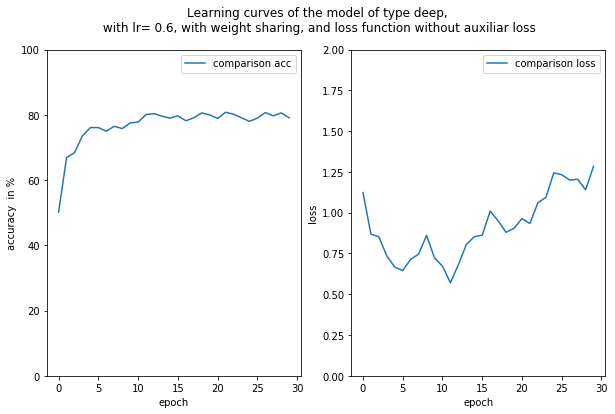

architecture                                                      deep
training mode                                       with auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb28383a6a8>
number parameters                                                98697
Name: 1, dtype: object

### Model:
     - deep
     - with auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

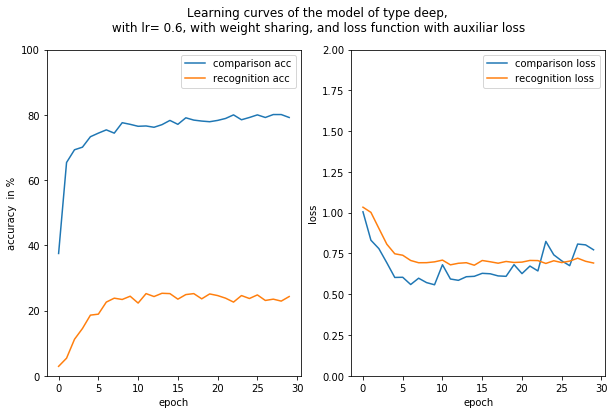

architecture                                                      deep
training mode                                    without auxiliar loss
weight sharing                                                   False
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb2838e1598>
number parameters                                                98697
Name: 2, dtype: object

### Model:
     - deep
     - without auxiliar loss
     - without weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

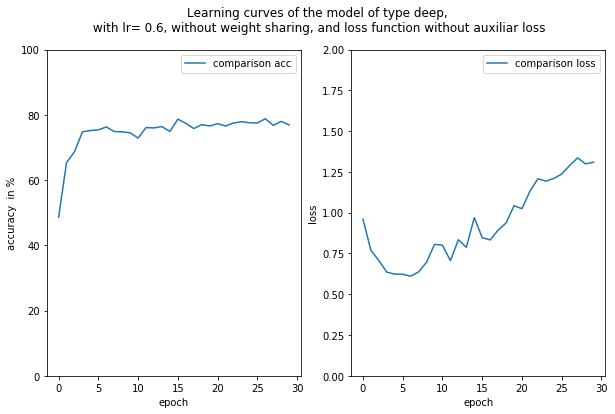

architecture                                                      deep
training mode                                       with auxiliar loss
weight sharing                                                   False
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283a0e510>
number parameters                                                98697
Name: 3, dtype: object

### Model:
     - deep
     - with auxiliar loss
     - without weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

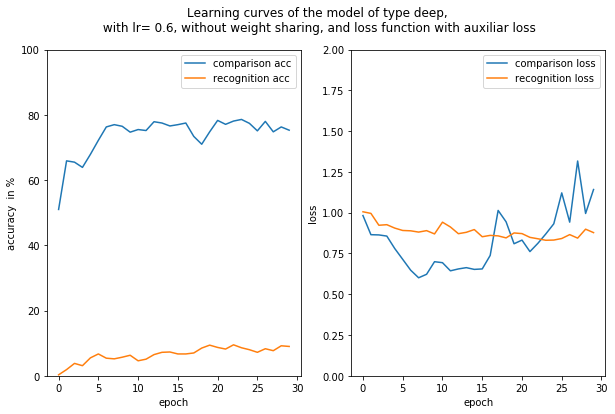

architecture                                           fully connected
training mode                                    without auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Print()\...
loss function                    <function <lambda> at 0x7fb283a259d8>
number parameters                                                99067
Name: 4, dtype: object

### Model:
     - fully connected
     - without auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

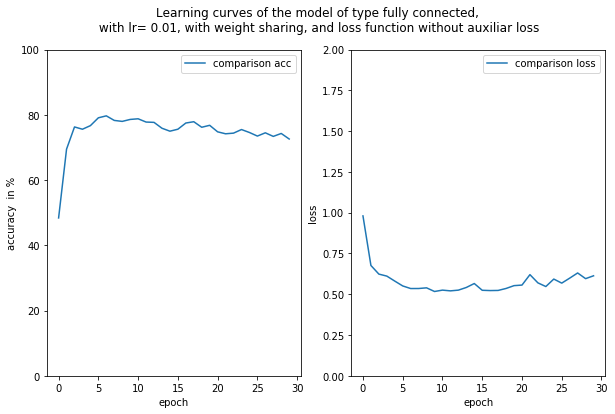

architecture                                           fully connected
training mode                                       with auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Print()\...
loss function                    <function <lambda> at 0x7fb283c3aea0>
number parameters                                                99067
Name: 5, dtype: object

### Model:
     - fully connected
     - with auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

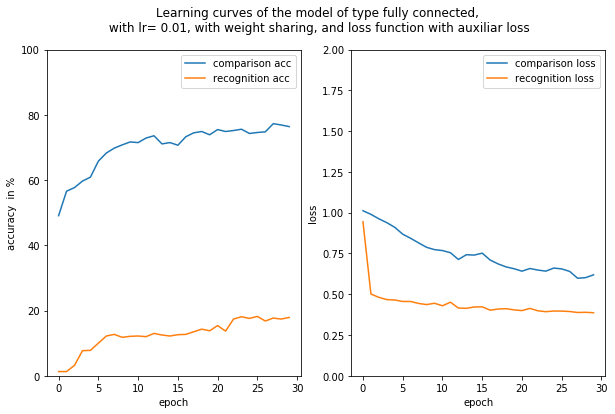

architecture                                           fully connected
training mode                                    without auxiliar loss
weight sharing                                                   False
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Print()\...
loss function                    <function <lambda> at 0x7fb283c27378>
number parameters                                                99067
Name: 6, dtype: object

### Model:
     - fully connected
     - without auxiliar loss
     - without weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

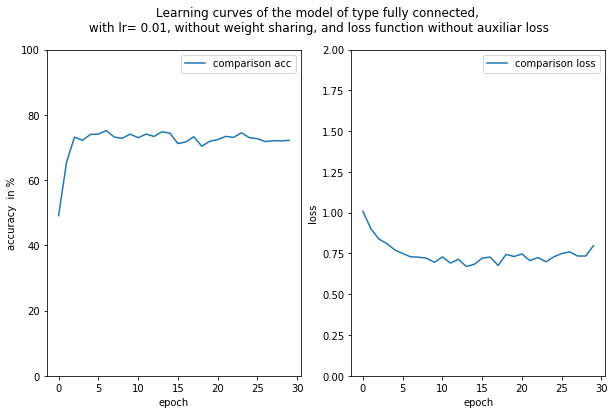

architecture                                           fully connected
training mode                                       with auxiliar loss
weight sharing                                                   False
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Print()\...
loss function                    <function <lambda> at 0x7fb283baf840>
number parameters                                                99067
Name: 7, dtype: object

### Model:
     - fully connected
     - with auxiliar loss
     - without weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

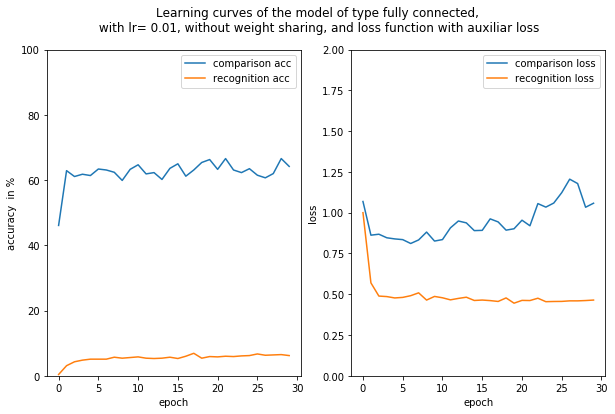

architecture                                        deep with sigmoids
training mode                                    without auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283b897b8>
number parameters                                                98697
Name: 8, dtype: object

### Model:
     - deep with sigmoids
     - without auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

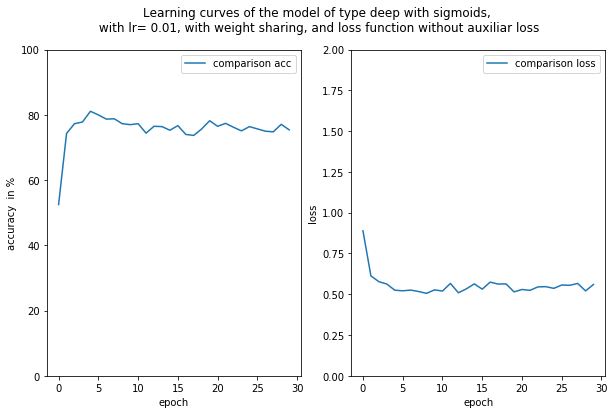

architecture                                        deep with sigmoids
training mode                                       with auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283ae0730>
number parameters                                                98697
Name: 9, dtype: object

### Model:
     - deep with sigmoids
     - with auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

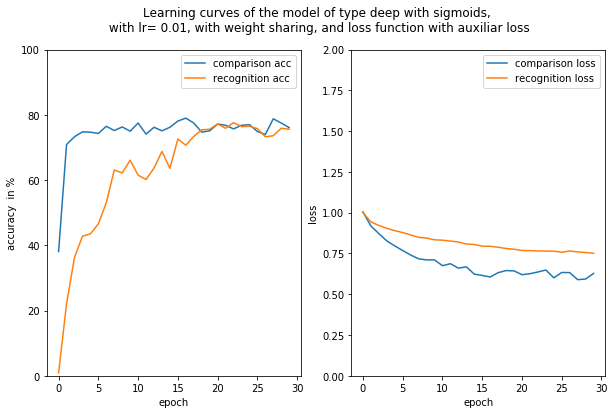

architecture                                        deep with sigmoids
training mode                                    without auxiliar loss
weight sharing                                                   False
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283ac86a8>
number parameters                                                98697
Name: 10, dtype: object

### Model:
     - deep with sigmoids
     - without auxiliar loss
     - without weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

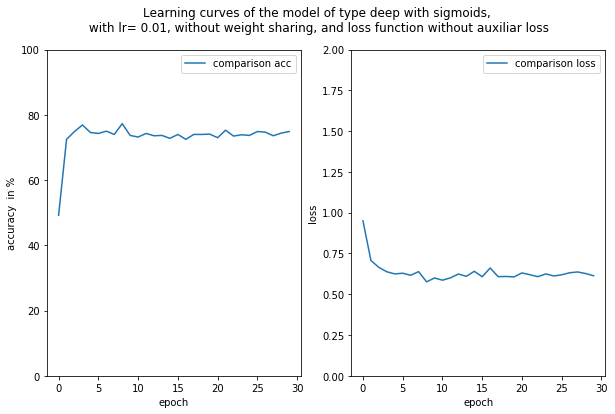

architecture                                        deep with sigmoids
training mode                                       with auxiliar loss
weight sharing                                                   False
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283c77620>
number parameters                                                98697
Name: 11, dtype: object

### Model:
     - deep with sigmoids
     - with auxiliar loss
     - without weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

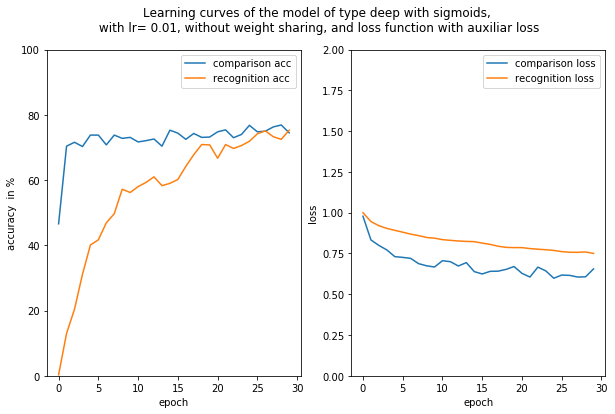

In [490]:
for j in range(10):
    for i in range(len(DATA)):
            print('j='+str(j), 'i='+str(i))
            run_number(i)
DATA.to_csv('./DATA.csv')

architecture                                        deep with sigmoids
training mode                                       with auxiliar loss
weight sharing                                                    True
history                                                    comparis...
model                CNN(\n  (arch): Sequential(\n    (0): Conv2d(1...
loss function                    <function <lambda> at 0x7fb283ae0730>
number parameters                                                98697
Name: 9, dtype: object

### Model:
     - deep with sigmoids
     - with auxiliar loss
     - with weight sharing
    

epoch: (../ 29 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

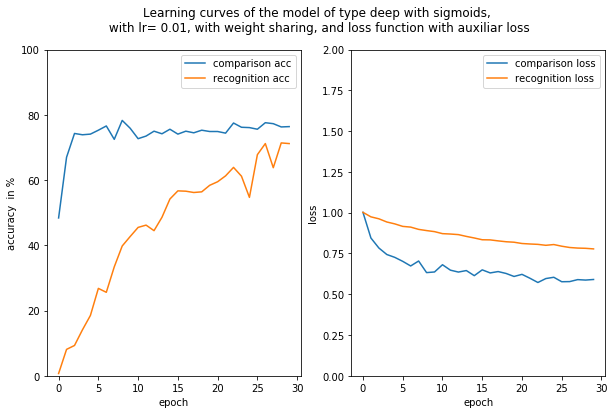

/home/tomas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


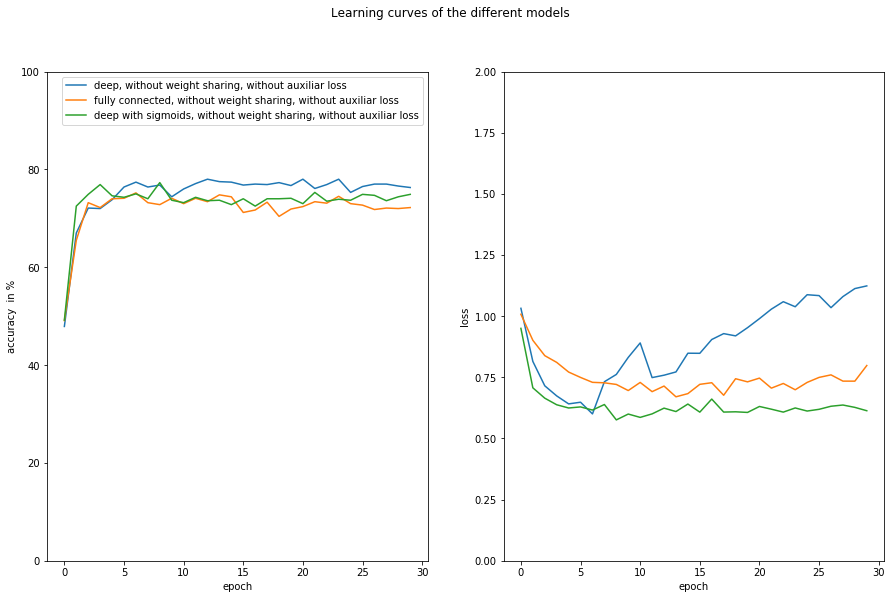

In [535]:
run_number(9)
data = DATA[(DATA['weight sharing']==False) & (DATA['training mode']=='without auxiliar loss')]
accuracy_comparison_graph(data)

In [574]:
data = DATA[(DATA['weight sharing']==False) & (DATA['training mode']=='without auxiliar loss')]
accuracy_comparison_graph(data, plot_loss = False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/tomas/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-574-91345104a3ae>", line 2, in <module>
    accuracy_comparison_graph(data, plot_loss = False)
  File "<ipython-input-573-7739510be300>", line 14, in accuracy_comparison_graph
    if plos_loss: plt.suptitle('Learning curves of the different models '+title)
NameError: name 'plos_loss' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tomas/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tomas/anaconda3/l

NameError: name 'plos_loss' is not defined

In [133]:
def print_number(i,j=0):
    '''prints model i"s history j'''
    data_row = DATA.iloc[i]
    # history of historys
    historys = data_row['history']
    display(historys)
    plot_graphs(data_row, historys.iloc[j])

In [575]:
def accuracy_comparison_graph(data, title='', plot_loss = True):
    if plot_loss: plt.figure(figsize=(15,6))
    else: plt.figure(figsize=(7,6))

    for i, data_row in data.iterrows():
        d = data_row['history'].iloc[-1]
        


        if plot_loss: plt.subplot(1,2,1)
        else: plt.subplot(1,1,1)
        

        plt.suptitle('Learning curves of the different models '+title)

        plt.plot(d['comparison acc'], label=data_row['architecture']+', '\
                 +('with weight sharing' if data_row['weight sharing'] else 'without weight sharing')+\
                ', '+data_row['training mode'])
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy  in %')
        plt.ylim((0,100))
        
        
        if plot_loss:
            # plotting loss
            plt.subplot(1,2,2)



            plt.plot(d['comparison loss'], label='comparison loss')

            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.ylim((0,2))
    
    plt.show()

/home/tomas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


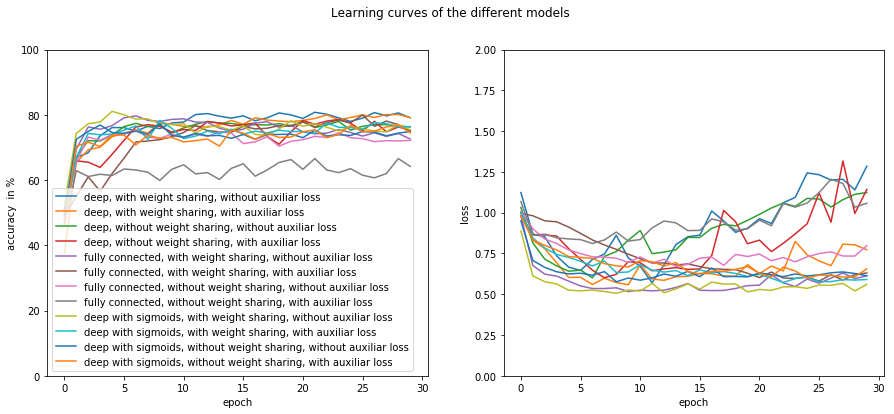

In [555]:
accuracy_comparison_graph(DATA, '')

In [472]:
def create_ranking(data):
    res = pd.DataFrame()
    for i, data_row in data.iterrows():
        d = data_row['history'].iloc[-1]
        new_row = data_row[['architecture', 'training mode', 'weight sharing']]
        new_row.loc['max accuracy']= max([float(i) for i in d['comparison acc']])
        res = res.append(new_row)
    return res

In [587]:
display(Markdown('### Best of each architecture'))
display(create_ranking(DATA).groupby('architecture').max().sort_values(['max accuracy'], ascending = False))


display(Markdown('### Ranking of all models'))
display(create_ranking(DATA).sort_values(['max accuracy'], ascending = False))

display(Markdown('### Weight sharing vs. not sharing'))
display(create_ranking(DATA).groupby('weight sharing').mean().sort_values(['max accuracy'], ascending = False))


display(Markdown('### Best with auxiliar loss'))
display(create_ranking(DATA[DATA['training mode']== 'with auxiliar loss']).sort_values(['max accuracy'], ascending = False))


display(Markdown('### Benefits of auxiliar loss'))
display(create_ranking(DATA[DATA['weight sharing']==False]).sort_values(['max accuracy'], ascending = False))

### Best of each architecture

,max accuracy,training mode,weight sharing
architecture,,,
deep with sigmoids,81.099998,without auxiliar loss,1.0
deep,80.800003,without auxiliar loss,1.0
fully connected,80.000000,without auxiliar loss,1.0


### Ranking of all models

,architecture,max accuracy,training mode,weight sharing
8,deep with sigmoids,81.099998,without auxiliar loss,1.0
0,deep,80.800003,without auxiliar loss,1.0
1,deep,80.099998,with auxiliar loss,1.0
5,fully connected,80.000000,with auxiliar loss,1.0
4,fully connected,79.699997,without auxiliar loss,1.0
3,deep,78.599998,with auxiliar loss,0.0
9,deep with sigmoids,78.300003,with auxiliar loss,1.0
2,deep,78.000000,without auxiliar loss,0.0
10,deep with sigmoids,77.300003,without auxiliar loss,0.0
11,deep with sigmoids,76.900002,with auxiliar loss,0.0


### Weight sharing vs. not sharing

,max accuracy
weight sharing,
1.0,80.000000
0.0,75.433333


### Best with auxiliar loss

,architecture,max accuracy,training mode,weight sharing
1,deep,80.099998,with auxiliar loss,1.0
5,fully connected,80.000000,with auxiliar loss,1.0
3,deep,78.599998,with auxiliar loss,0.0
9,deep with sigmoids,78.300003,with auxiliar loss,1.0
11,deep with sigmoids,76.900002,with auxiliar loss,0.0
7,fully connected,66.599998,with auxiliar loss,0.0


### Benefits of auxiliar loss

,architecture,max accuracy,training mode,weight sharing
3,deep,78.599998,with auxiliar loss,0.0
2,deep,78.000000,without auxiliar loss,0.0
10,deep with sigmoids,77.300003,without auxiliar loss,0.0
11,deep with sigmoids,76.900002,with auxiliar loss,0.0
6,fully connected,75.199997,without auxiliar loss,0.0
7,fully connected,66.599998,with auxiliar loss,0.0
